In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
import rpy2.robjects as R
%load_ext rpy2.ipython

C:\Users\sandervancranenburgh\AppData\Roaming\Python\Python38\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%capture
%%R
# Clear memory
rm(list=ls())

# Load Apollo library
library(apollo)

# Initialise code
apollo_initialise()

### Load the data

In [4]:
# Reading dataset
df = pd.read_csv('data_CV_DCM.csv')

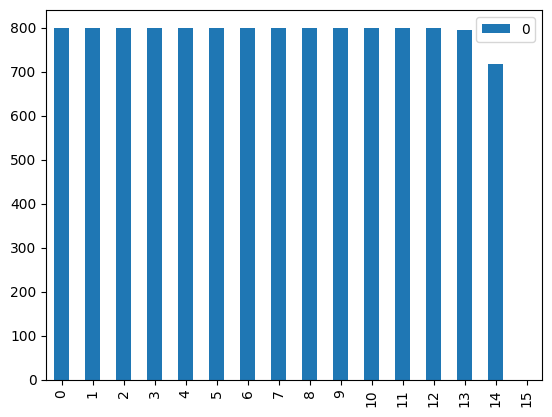

In [5]:
# Choice task per individual
cs = pd.DataFrame([(df['RID'].value_counts() > n).sum()
                  for n in range(16)]).plot.bar()


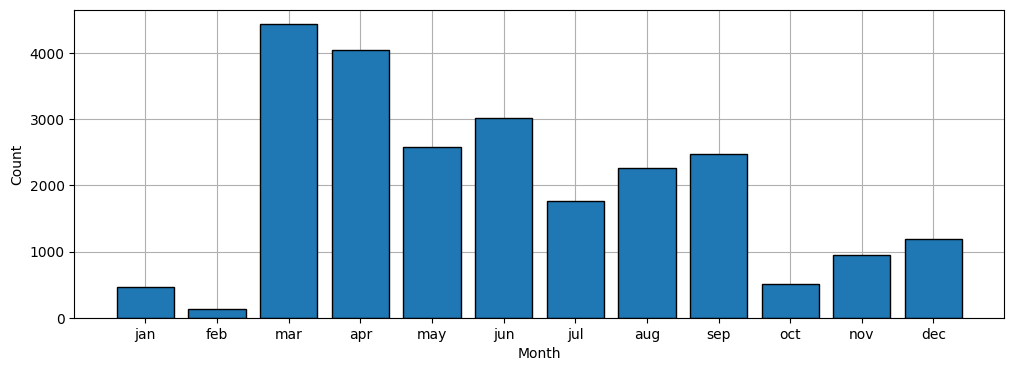

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
n_bins = np.linspace(0.5, 12.5, num=13)
ax.hist(pd.concat((df['IMG_MONTH1'], df['IMG_MONTH2']),
        axis=0), bins=n_bins, edgecolor='black', rwidth=0.80)
ax.set_ylabel('Count')
ax.set_xlabel('Month')
ax.grid()
ax.set_axisbelow(True)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
plt.show()


In [7]:
# Add regions to df
df['region_N'] = (df['PROVINCE'].isin([1, 3, 5])).astype(int)       # Groningen, Friesland, Drenthe
df['region_E'] = (df['PROVINCE'].isin([2, 4, 9])).astype(int)       # Overijssel, Flevoland, Gelderland
df['region_S'] = (df['PROVINCE'].isin([6, 7])).astype(int)          # Noord-Brabant, Limburg
df['region_W'] = (df['PROVINCE'].isin([8, 10, 11, 12])).astype(int) # Utrecht, Noord-Holland, Zuid-Holland, Zeeland
df[['region_N', 'region_E', 'region_S', 'region_W']].sum()/(df[['region_N', 'region_E', 'region_S', 'region_W']].sum().sum())

region_N    0.116353
region_E    0.231531
region_S    0.243116
region_W    0.408999
dtype: float64

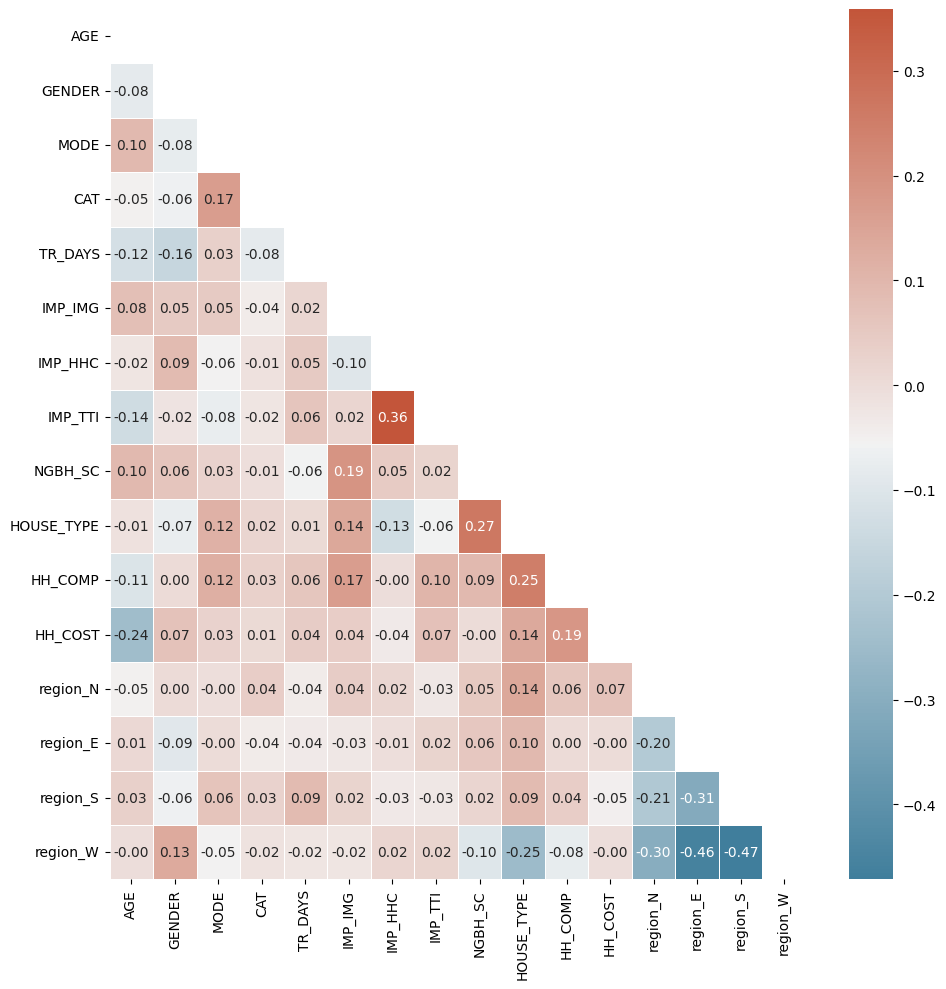

In [23]:
plotcorr = 1
if plotcorr == 1:
    import seaborn as sns
    # heatmap of correlations
    # Create plot
    fig, axes = plt.subplots(figsize=(10, 10))
    fig.set_tight_layout(True)

    # Compute correlation matrix
    corr = df[['AGE', 'GENDER', 'MODE', 'CAT', 'TR_DAYS', 'IMP_IMG', 'IMP_HHC', 'IMP_TTI', 'NGBH_SC',
               'HOUSE_TYPE', 'HH_COMP', 'HH_COST', 'region_N', 'region_E', 'region_S', 'region_W']].corr()

    # Create upper triangular matrix to mask the upper triangular part of the heatmap
    corr_mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap (because it looks better)
    corr_cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=corr_mask, cmap=corr_cmap,
                annot=True, square=False, linewidths=.5, fmt="0.2f",ax=axes)
    plt.show()

In [9]:
# Handle categorical data
categorical_features = ['HH_COMP', 'AGE', 'MODE']
df_cat = pd.get_dummies(df[categorical_features], columns=categorical_features)

# Concatenate the categorical data and the original df
df = pd.concat([df, df_cat], axis=1).sort_values('RID')

### Select the features and create test and train dataframes

In [10]:
# Create dataframes
features = ['RID', 'C1', 'TT1', 'C2', 'TT2', 'CHOICE', 'IMG_MONTH1', 'IMG_MONTH2', 'IMG_YEAR1', 'IMG_YEAR2', 'MODE', 'CAT', 'TR_DAYS', 'IMP_IMG', 'IMP_HHC', 'IMP_TTI','GENDER', 'AGE', 'NGBH_SC', 'HOUSE_TYPE', 'HH_COMP', 'HH_COST', 'region_N', 'region_E', 'region_S', 'region_W','test', 'train']

# Split the data frames
df_train = df[features][df.train == 1].sort_values('RID')
df_test = df[features][df.test == 1].sort_values('RID')


In [11]:
%%R -i df_train

# Push df_train to R
database = df_train


### Benchmark RUM-MNL models
* Model 1. Cost, Time
* Model 2: Cost, Time, and Months

Model 1: Cost, Time

In [12]:
%%capture
%%R
# Set core controls
apollo_control = list(
    modelName = "MNL",
    modelDescr = "MNL model with Cost & Time attributes",
    indivID = "RID",
    noDiagnostics = TRUE)

# Vector of parameters, including any that are kept fixed in estimation
apollo_beta = c(B_tti=0,
                B_hhc=0)
apollo_fixed = c()

apollo_inputs = apollo_validateInputs()
apollo_probabilities = function(apollo_beta, apollo_inputs, functionality="estimate"){

    # Attach inputs and detach after function exit
    apollo_attach(apollo_beta, apollo_inputs)
    on.exit(apollo_detach(apollo_beta, apollo_inputs))

    # Create list of probabilities P
    P = list()
    V = list()
    V[['Alt1']] = B_hhc * (C1/225) + B_tti * (TT1/15)
    V[['Alt2']] = B_hhc * (C2/225) + B_tti * (TT2/15)

    # Define settings for MNL model component
    mnl_settings = list(alternatives=c(Alt1=1, Alt2=2),
                        avail=list(Alt1=1, Alt2=1), choiceVar=CHOICE, V=V)

    # Compute probabilities using MNL model
    P[['model']] = apollo_mnl(mnl_settings, functionality)

    # Take product across observation for same individual and Prepare and return outputs of function
    P = apollo_panelProd(P, apollo_inputs, functionality)
    P = apollo_prepareProb(P, apollo_inputs, functionality)
    return (P)
}
# Estimate
model1 = apollo_estimate(apollo_beta, apollo_fixed,
                         apollo_probabilities,
                         apollo_inputs,
                         list(writeIter=FALSE, estimationRoutine='bgw'))

# Compute Value-of-Travel-Time
deltaMethod_settings = list(expression=c(VTT="B_tti/B_hhc"))
apollo_deltaMethod(model1, deltaMethod_settings)

In [13]:
%%R -o model1,apollo_inputs1

# Show estimation results
apollo_inputs1 = apollo_inputs
apollo_probabilities1 = apollo_probabilities
apollo_modelOutput(model1)

Model run by sandervancranenburgh using Apollo 0.2.9 on R 4.2.2 for Windows.
www.ApolloChoiceModelling.com

Model name                                  : MNL
Model description                           : MNL model with Cost & Time attributes
Model run at                                : 2023-03-31 14:46:03
Estimation method                           : bgw
Model diagnosis                             : X- and relative function convergence
Number of individuals                       : 800
Number of rows in database                  : 9784
Number of modelled outcomes                 : 9784

Number of cores used                        :  1 
Model without mixing

LL(start)                                   : -6781.75
LL at equal shares, LL(0)                   : -6781.75
LL at observed shares, LL(C)                : -6780.69
LL(final)                                   : -5953.91
Rho-squared vs equal shares                  :  0.1221 
Adj.Rho-squared vs equal shares              :  0.1218 
Rh

C:\Users\sandervancranenburgh\AppData\Roaming\Python\Python38\site-packages\rpy2\robjects\vectors.py:1010: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Model 2: Cost, Time, and Months

In [14]:
%%capture
%%R
# Set core controls
apollo_control = list(
    modelName = "MNL",
    modelDescr = "MNL model with Cost, Time & Month attributes",
    indivID = "RID",
    noDiagnostics = TRUE)

# Vector of parameters, including any that are kept fixed in estimation
apollo_beta = c(B_tti=0,
                B_hhc=0,
                B_jan=0,
                B_feb=0,
                B_mar=0,
                B_apr=0,
                B_may=0,
                B_jun=0,
                B_jul=0,
                B_aug=0,
                B_sep=0,
                B_oct=0,
                B_nov=0,
                B_dec=0)
apollo_fixed = c("B_dec")

apollo_inputs = apollo_validateInputs()
apollo_probabilities = function(apollo_beta, apollo_inputs, functionality="estimate"){

    # Attach inputs and detach after function exit
    apollo_attach(apollo_beta, apollo_inputs)
    on.exit(apollo_detach(apollo_beta, apollo_inputs))

    # Create list of probabilities P
    P = list()
    V = list()
    V[['Alt1']] = B_hhc * (C1/225) + B_tti * (TT1/15) + B_jan * (IMG_MONTH1 == 1) + B_feb * (IMG_MONTH1 == 2) + B_mar * (IMG_MONTH1 == 3) + B_apr * (IMG_MONTH1 == 4) + B_may * (IMG_MONTH1 == 5) + B_jun * (
        IMG_MONTH1 == 6) + B_jul * (IMG_MONTH1 == 7) + B_aug * (IMG_MONTH1 == 8) + B_sep * (IMG_MONTH1 == 9) + B_oct * (IMG_MONTH1 == 10) + B_nov * (IMG_MONTH1 == 11) + B_dec * (IMG_MONTH1 == 12)
    V[['Alt2']] = B_hhc * (C2/225) + B_tti * (TT2/15) + B_jan * (IMG_MONTH2 == 1) + B_feb * (IMG_MONTH2 == 2) + B_mar * (IMG_MONTH2 == 3) + B_apr * (IMG_MONTH2 == 4) + B_may * (IMG_MONTH2 == 5) + B_jun * (
        IMG_MONTH2 == 6) + B_jul * (IMG_MONTH2 == 7) + B_aug * (IMG_MONTH2 == 8) + B_sep * (IMG_MONTH2 == 9) + B_oct * (IMG_MONTH2 == 10) + B_nov * (IMG_MONTH2 == 11) + B_dec * (IMG_MONTH2 == 12)

    # Define settings for MNL model component
    mnl_settings = list(alternatives=c(Alt1=1, Alt2=2),
                        avail=list(Alt1=1, Alt2=1), choiceVar=CHOICE, V=V)

    # Compute probabilities using MNL model
    P[['model']] = apollo_mnl(mnl_settings, functionality)

    # Take product across observation for same individual and Prepare and return outputs of function
    P = apollo_panelProd(P, apollo_inputs, functionality)
    P = apollo_prepareProb(P, apollo_inputs, functionality)
    return (P)
}
# Estimate
model2 = apollo_estimate(apollo_beta, apollo_fixed,
                         apollo_probabilities,
                         apollo_inputs,
                         list(writeIter=FALSE, estimationRoutine='bgw'))

deltaMethod_settings = list(expression=c(VTT="B_tti/B_hhc"))
apollo_deltaMethod(model2, deltaMethod_settings)

In [15]:
%%R -o model2,apollo_inputs2
apollo_inputs2 = apollo_inputs
apollo_probabilities2 = apollo_probabilities
apollo_modelOutput(model2)

Model run by sandervancranenburgh using Apollo 0.2.9 on R 4.2.2 for Windows.
www.ApolloChoiceModelling.com

Model name                                  : MNL
Model description                           : MNL model with Cost, Time & Month attributes
Model run at                                : 2023-03-31 14:46:05
Estimation method                           : bgw
Model diagnosis                             : Relative function convergence
Number of individuals                       : 800
Number of rows in database                  : 9784
Number of modelled outcomes                 : 9784

Number of cores used                        :  1 
Model without mixing

LL(start)                                   : -6781.75
LL at equal shares, LL(0)                   : -6781.75
LL at observed shares, LL(C)                : -6780.69
LL(final)                                   : -5930.52
Rho-squared vs equal shares                  :  0.1255 
Adj.Rho-squared vs equal shares              :  0.1236 
Rh

Compute the performance on the test data set

In [16]:
%%capture
%%R -i df_test -o pred_test_model1,pred_test_model2

# Push df_train to R
database = df_test
apollo_inputs = apollo_validateInputs()

# Compute predictions on the test set
pred_test_model1 = apollo_prediction(model1,
                                     apollo_probabilities1,
                                     apollo_inputs)

pred_test_model2 = apollo_prediction(model2,
                                     apollo_probabilities2,
                                     apollo_inputs)

In [19]:
# Compute and report the log-likelihood
LL_test_model1 = np.sum(np.log(pred_test_model1['chosen']))
LL_test_model2 = np.sum(np.log(pred_test_model2['chosen']))
print(f'LL_test_model1\t {LL_test_model1:0.3f}')
print(f'LL_test_model2\t {LL_test_model2:0.3f}')

LL_test_model1	 -1193.654
LL_test_model2	 -1187.341


Create output table

In [18]:
ls_report_mod = ['nObs', 'finalLL', 'numParams', 'rho2_0', 'BIC']
ls_report_inp = ['B_hhc', 'B_tti', 'B_emb', 'B_jan', 'B_feb', 'B_mar', 'B_apr','B_may', 'B_jun', 'B_jul', 'B_aug', 'B_sep', 'B_oct', 'B_nov', 'B_dec']
models_nums = ['1', '2']

df_results = pd.DataFrame()
for m in models_nums:
    model = 'model' + m
    inputs_report = 'apollo_inputs' + m
    beta = list(eval(inputs_report)['apollo_beta_names'])
    model_name = eval(inputs_report)['apollo_control']['modelDescr'][0]
    for n in ls_report_mod:
        df_results.loc[n, model_name] = (eval(model)[n][0])
    for n in ls_report_inp:
        if n in beta:
            df_results.loc[n, model_name] = eval(
                model)['estimate'][beta.index(n)]

df_results.fillna(0, inplace=True)
df_results.round(4)


,MNL model with Cost & Time attributes,"MNL model with Cost, Time & Month attributes"
nObs,9784.0000,9784.0000
finalLL,-5953.9084,-5930.5193
numParams,2.0000,13.0000
rho2_0,0.1221,0.1255
BIC,11926.1938,11980.4892
B_hhc,-0.8635,-0.8655
B_tti,-0.2079,-0.2081
B_jan,0.0000,0.4579
B_feb,0.0000,0.0244
B_mar,0.0000,0.0952
